In [257]:
! pip install scikit-optimize
! pip install hyperopt
! pip install graphviz
! pip install xgboost

In [258]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
import pydotplus

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, LeaveOneOut, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import metrics

from hyperopt import hp, fmin, tpe, Trials, space_eval
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import ADASYN
from IPython.display import Image
from xgboost import XGBClassifier


Importing the training dataset and test dataset that has been preprocessed by the fixed preprocessing file, also saving them in other variables that save the data before the balancing algorithms.

In [293]:
training_df = pd.read_csv("./training_preprocessed.csv")
test_df = pd.read_csv("./test_preprocessed.csv")
y = training_df['Target']
training_df = training_df.drop('Target', axis=1)
training_df_init = training_df
y_init = y

Function that calculate all the evaluation metrics based on the confusion matrix.

In [260]:
def calculate_metrics(confusion_matrix):
    TP = confusion_matrix[0][0]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    TN = confusion_matrix[1][1]

    accuracy = (TP + TN) / (TP + FP + FN + TN)
    precision = TP / (TP + FP)
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)
    f1_score = 2 * (precision * tpr) / (precision + tpr)

    return accuracy, precision, tpr, fpr, f1_score

# Balancing unbalanced data

First of all, we will make sure that the training data is balanced, we will use the ADASYN algorithm for oversampling the minority class and then we will use the Tomek-Link algorithm for undersampling the majority class.

We want to check the distribution of the initial data.

In [261]:
y.value_counts()

Target
0    425
1    241
Name: count, dtype: int64

First we will do ASASYN oversampling algorithem.

In [262]:
oversample = ADASYN(random_state = 42, sampling_strategy='minority')
training_df, y = oversample.fit_resample(training_df, y)
adasyn_data = pd.concat([pd.DataFrame(training_df),pd.DataFrame(y, columns=['Target'])], axis=1)
print(adasyn_data['Target'].value_counts())

Target
0    425
1    410
Name: count, dtype: int64


Now we will do TomekLink undersampling algorithem.

In [263]:

# Create an instance of TomekLinks with the defined parameters
tomek_links = TomekLinks(sampling_strategy='majority')

# Apply Tomek Links to the dataset
X_resampled, y_resampled = tomek_links.fit_resample(training_df, y)

# Convert the resampled data back to pandas DataFrame and Series if needed
training_df = pd.DataFrame(X_resampled, columns=training_df.columns)
y = pd.Series(y_resampled)
print(y.value_counts())

Target
1    410
0    334
Name: count, dtype: int64


The ratio between the majority and minority if 55%-45% and we will consider it a good ratio, better than before the balancing.

# Decision Tree Classifier

Making simple decisionTreeClassifier with cross validation method, and printing the tree.

In [264]:
X_train, X_test, y_train, y_test = train_test_split(training_df, y, test_size=0.25, random_state=42)
DTC = DecisionTreeClassifier(random_state=42)

DTC.fit(X_train, y_train)
y_pred = DTC.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))

Accuracy Score: 0.7365591397849462


,0,1
0,55,29
1,20,82


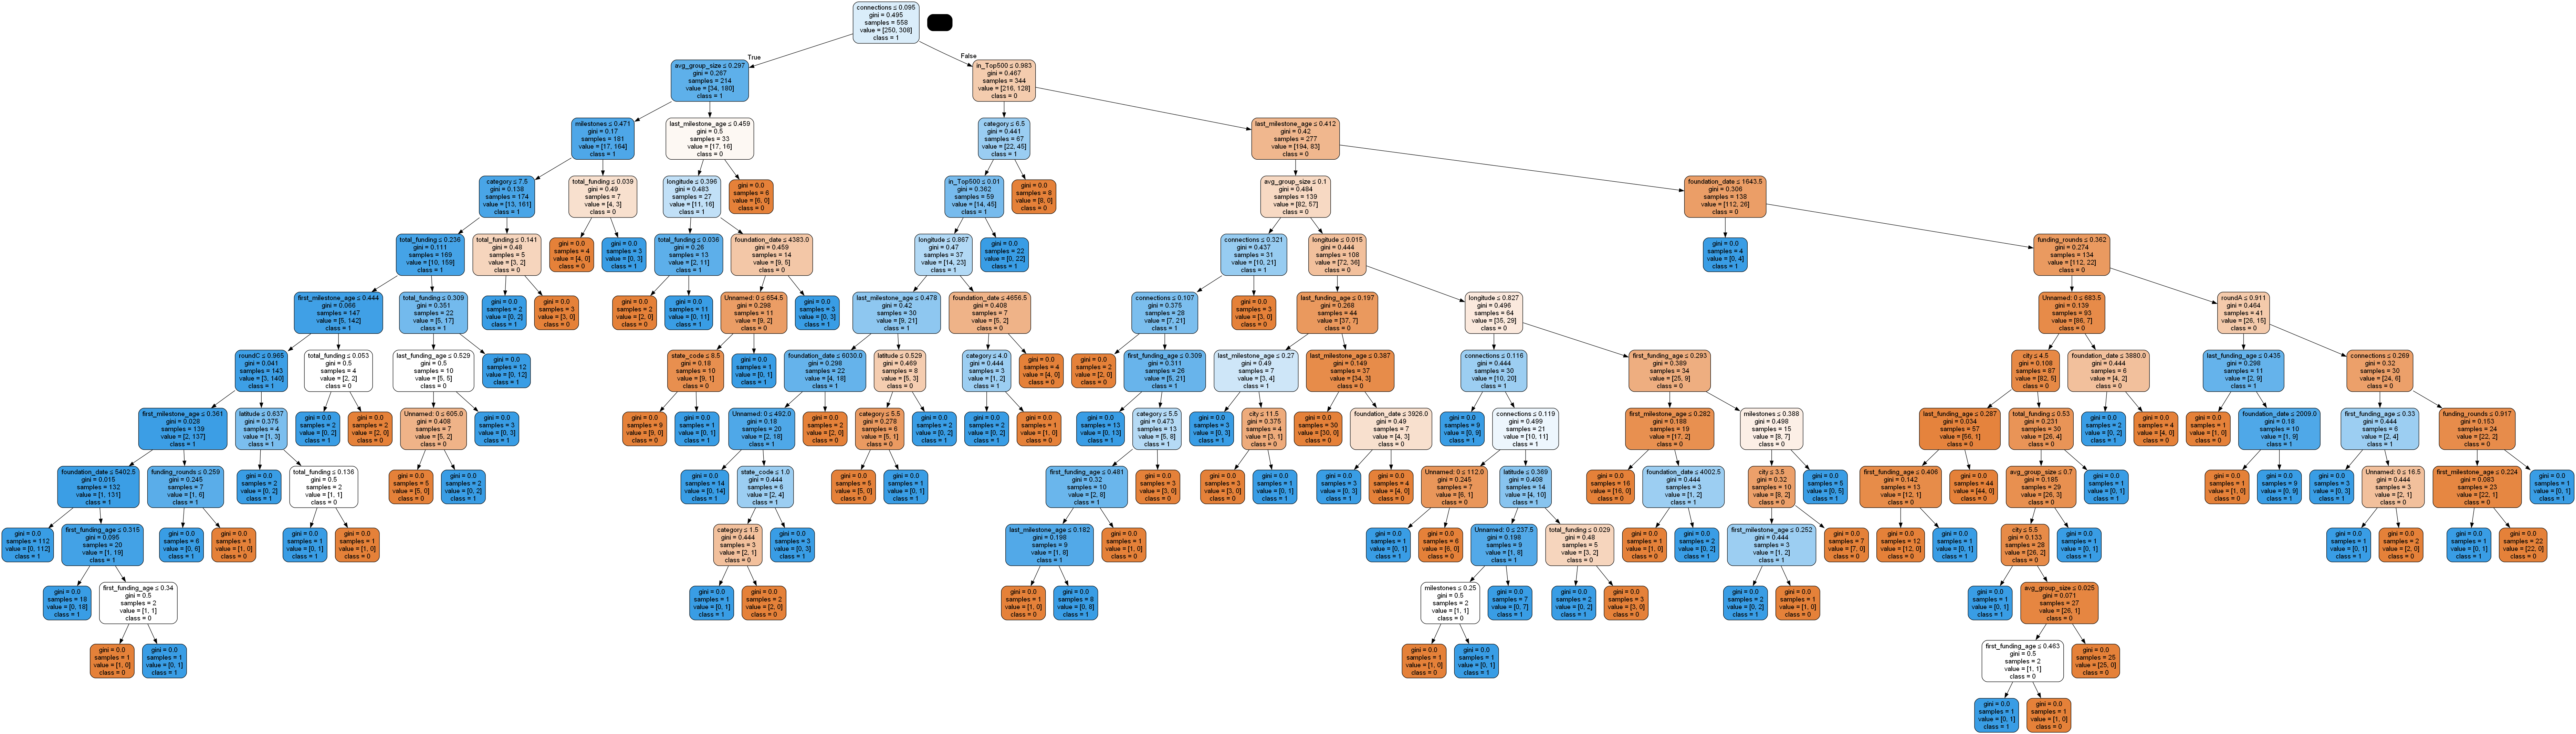

In [265]:
dot = export_graphviz(DTC, filled=True, rounded=True, 
                special_characters=True,feature_names = training_df.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot)  
Image(graph.create_png())

We can see in the DTC that it is overfitting as the tree is huge and his accuracy low, we will prove it with an example.

In [266]:
y_train_pred = DTC.predict(X_train)
print(metrics.accuracy_score(y_train, y_train_pred))
pd.DataFrame(metrics.confusion_matrix(y_train, y_train_pred))

1.0


,0,1
0,250,0
1,0,308


We will now change the DTC parameters in a simple way by only changing the min_samples_leaf paramater, to make sure the tree wont overfit

min_samples_leaf: 31
accuracy: 0.7956989247311828, precision: 0.7857142857142857, tpr: 0.7674418604651163, fpr: 0.18, f1_score: 0.7764705882352941


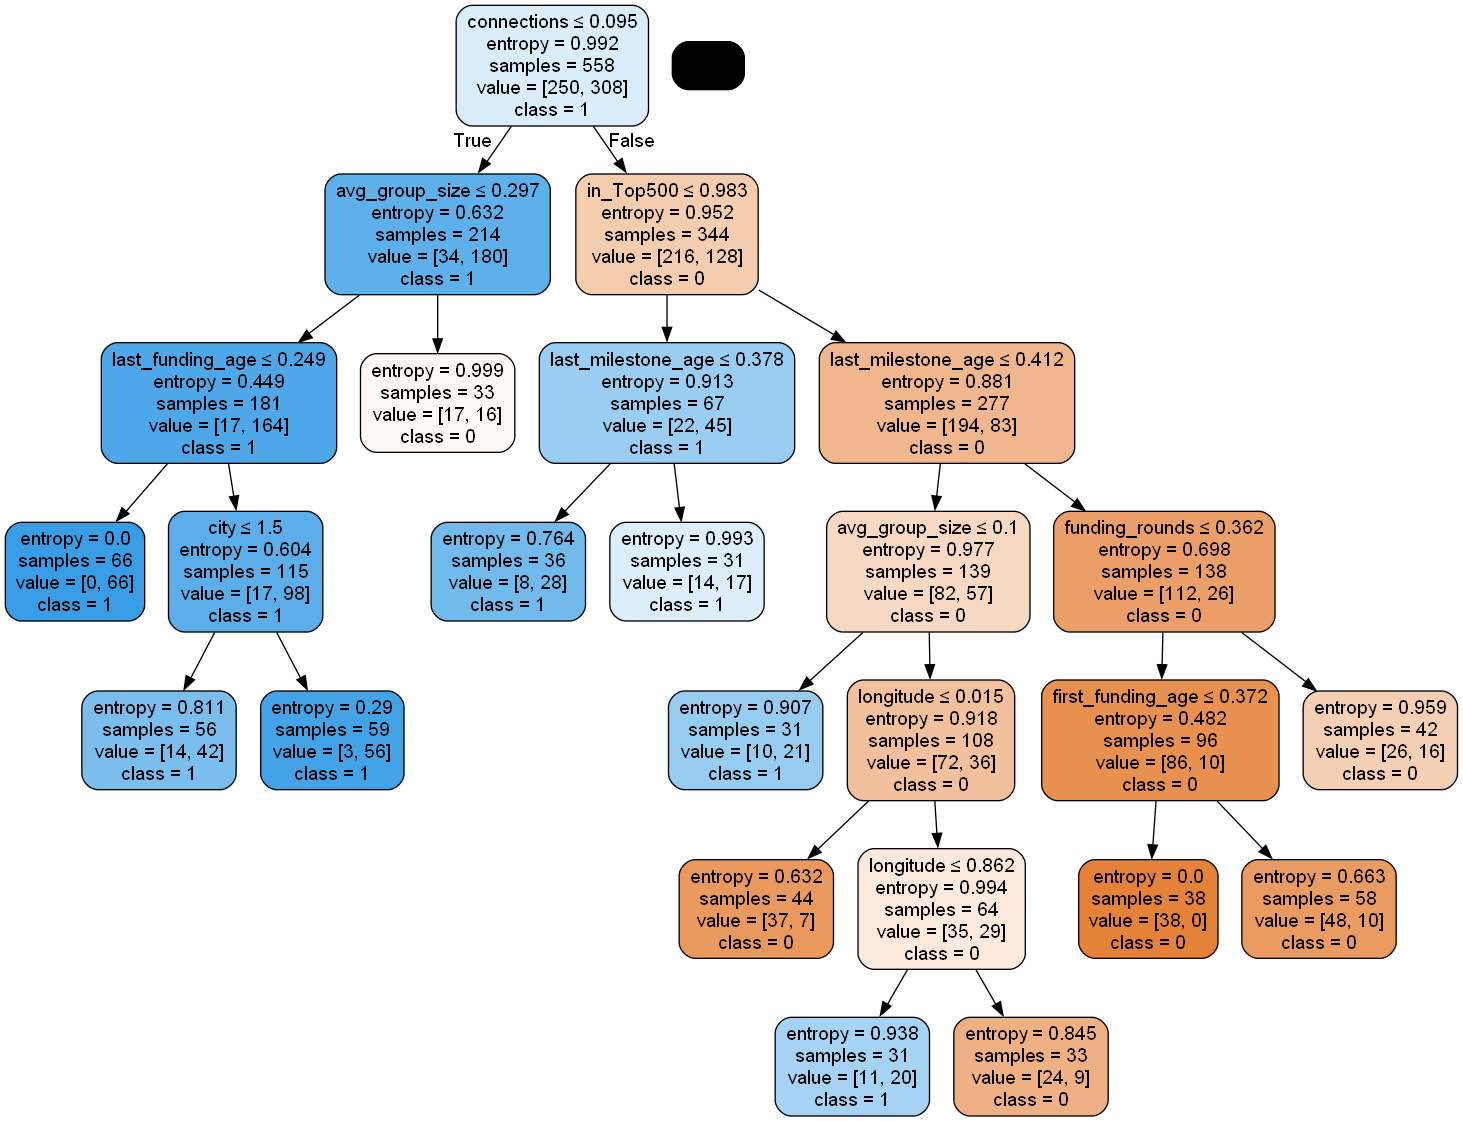

In [267]:
best_min_samples_leaf = 1
best_accuracy = 0
cm = None
best_DTC = None
for min_samples_leaf in range(1,50):
    DTC2 = DecisionTreeClassifier(criterion='entropy', splitter='best', min_samples_leaf = min_samples_leaf, random_state=42) 
    DTC2 = DTC2.fit(X_train,y_train)
    y_pred = DTC2.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_min_samples_leaf = min_samples_leaf
            best_DTC = DTC2
            cm = metrics.confusion_matrix(y_test, y_pred)
            
print(f'min_samples_leaf: {best_min_samples_leaf}')
accuracy, precision, tpr, fpr, f1_score = calculate_metrics(cm)
print(f'accuracy: {accuracy}, precision: {precision}, tpr: {tpr}, fpr: {fpr}, f1_score: {f1_score}')

dot = export_graphviz(best_DTC, filled=True, rounded=True, 
                special_characters=True,feature_names = training_df.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot)
Image(graph.create_png())

accuracy: measure the overall correct predictions.

precision: measure the proportion of the correct positive predictions out of all positive predictions.

tpr: measure the proportion of the correct positive predictions out of all actual positive cases.

fpr: measure the proportion of the incorrect positive predictions out of all actual negetive cases.

f1 score: combine precision and recall(tpr) into one metric that represent their harmonic mean.

We saw all the evaluation metrics but the most important one in our opinion is the accuracy and precision
we chose precision beacuse we think its much more important to make sure that the startups that you invest in are gonna secceed,
and its not too bad if we lose some good startups

We saw that min_samples_leaf 31 is the best in accuracy and preventing overfitting, but now we want to test if its true for kFolds splitting and not only one validation split of the data

In [268]:
best_min_samples_leaf = 1
best_precision = 0
best_accuracy = 0
accuracies = []
precisions = []
best_DTC = None
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train = training_df.to_numpy()
for min_samples_leaf in range(1,40):
    cm = []
    precision = []
    for train_index, test_index in kf.split(train):
        X_train, X_test = train[train_index], train[test_index]
        y_train, y_test = y[train_index], y[test_index]

        DTC2 = DecisionTreeClassifier(criterion='entropy', splitter='best', min_samples_leaf = min_samples_leaf, random_state=42) 
        DTC2.fit(X_train, y_train)
        y_pred = DTC2.predict(X_test)
        cm.append(metrics.confusion_matrix(y_test, y_pred))
        precision.append(metrics.precision_score(y_test, y_pred, average='weighted'))

    result_cm = np.zeros((2,2))
    for matrix in cm:
        result_cm += matrix
    result_cm = result_cm/len(cm)
    acc = (result_cm[0][0]+result_cm[1][1])/(result_cm[0][0]+result_cm[0][1]+result_cm[1][0]+result_cm[1][1])
    prs = np.average(precision)

    accuracies.append(acc)
    precisions.append(prs)
    if acc > best_accuracy:
            best_accuracy = acc
            best_precision = prs
            best_min_samples_leaf = min_samples_leaf
            best_DTC = DTC2
print(f'min_samples_leaf: {best_min_samples_leaf}, precision: {best_precision}, acuurecy: {best_accuracy}')



min_samples_leaf: 17, precision: 0.7847405832497731, acuurecy: 0.7809139784946236


We want to see the graphs of the accurecy and presicion as a function of the min_samples_tree to choose the best parameter

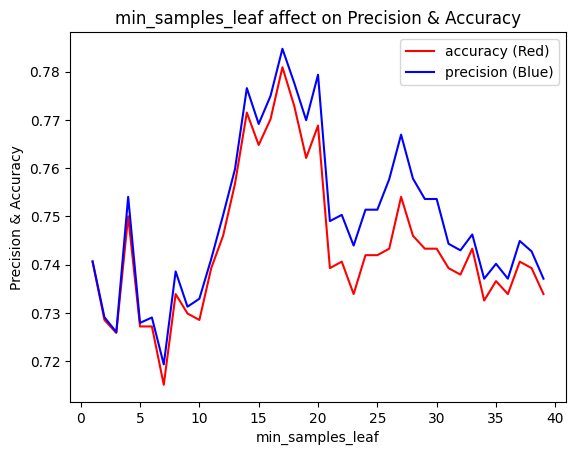

In [269]:
x = range(1,40)
plt.plot(x, accuracies, 'r-', label='accuracy (Red)')
plt.plot(x, precisions, 'b-', label='precision (Blue)')
plt.legend()

plt.xlabel('min_samples_leaf')
plt.ylabel('Precision & Accuracy')
plt.title('min_samples_leaf affect on Precision & Accuracy')

plt.show()

We noticed that the graphes looks very similar but they are correct. also min_samples_leaf = 17 is the best parameter as its not overfittinh and as the highest accurecy and very close to the highest precision, we will show the DTC

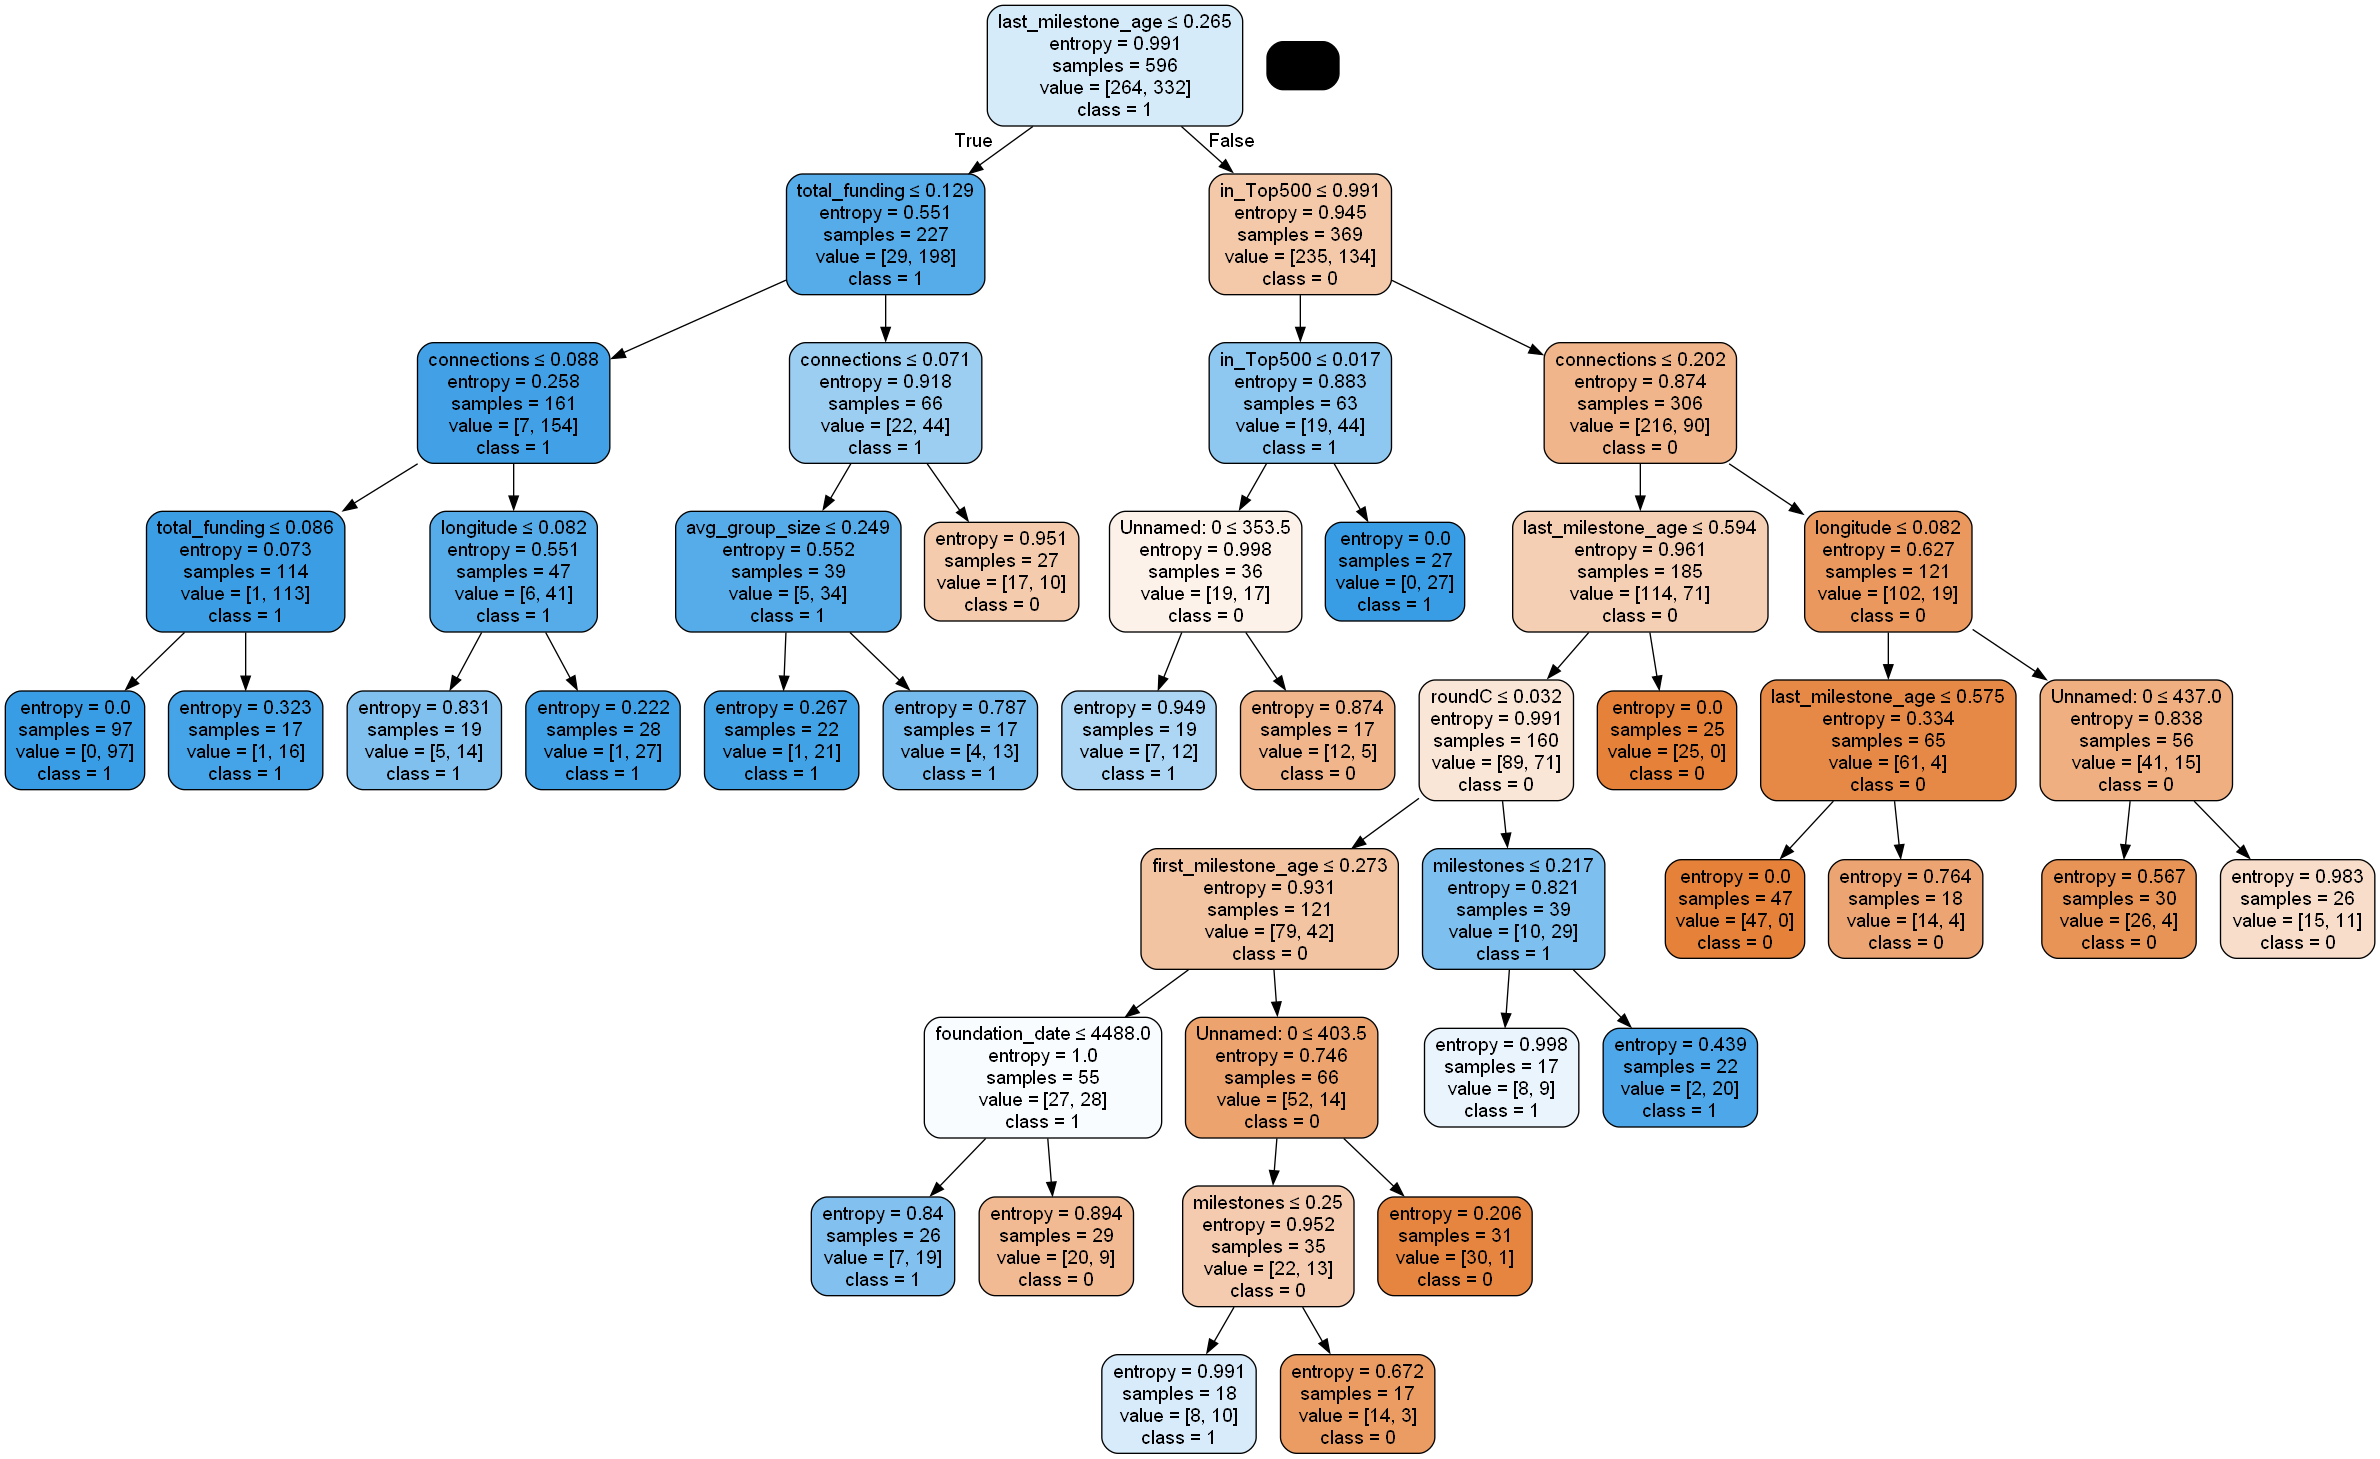

In [270]:
dot = export_graphviz(best_DTC, filled=True, rounded=True, 
                special_characters=True,feature_names = training_df.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot)
Image(graph.create_png())

We will try to do bagging algorithem to see if we can get much better results on the decision tree classifier, also using LeaveOneOut algorithem for the cross_validation method.

In [271]:
DTC3 = DecisionTreeClassifier(criterion='entropy', splitter='best', random_state=42)
bagging = BaggingClassifier(estimator=DTC3, n_estimators=10, random_state=42)
loo = LeaveOneOut()
y_true = []
y_pred = []
train = training_df.to_numpy()
for train_index, test_index in loo.split(train):
    X_train, X_test = train[train_index], train[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    bagging.fit(X_train, y_train)
    y_true.extend(y_test)
    y_pred.extend(bagging.predict(X_test))

cm = metrics.confusion_matrix(y_true, y_pred)
print("cm:", cm)
accuracy = metrics.accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)
precision = metrics.precision_score(y_true, y_pred)
print("Precision:", precision)
recall = metrics.recall_score(y_true, y_pred)
print("Recall:", recall)
f1 = metrics.f1_score(y_true, y_pred)
print("F1-score:", f1)


cm: [[283  51]
 [ 90 320]]
Accuracy: 0.8104838709677419
Precision: 0.862533692722372
Recall: 0.7804878048780488
F1-score: 0.8194622279129322


We found that the best classifier in the DTC we got is the bagging one with aproximatly 81% accuracy

In [272]:
best_Decision_Tree = bagging

# Random Forest

Instead of a specific decision tree, we will try to average several decision trees.

We will try first to find the best parameters for the trees using randomSearchCV on a large portion is the parameters.

In [273]:
X_train, X_test, y_train, y_test = train_test_split(training_df, y, test_size=0.25, random_state=42)
random_parameters = {'criterion' : ['gini', 'entropy'],
                     'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90 ,100],
                     'max_depth' : [4 ,5, 6, 7, 8, None],
                     'min_samples_leaf': [5, 10, 15, 20, 25, 30],
                     'min_samples_split' : [10, 15, 20, 25, 30, 35],
                     'max_features' : ['auto', 'log2']}

rf_classifier = RandomForestClassifier(random_state = 42)
RFC_random = RandomizedSearchCV(estimator = rf_classifier, param_distributions = random_parameters
                         , n_iter = 100, cv = 5, verbose=2, random_state = 42, n_jobs = -1, scoring='accuracy')
RFC_random.fit(X_train, y_train)
best_RFC_random = RFC_random.best_estimator_
y_pred = best_RFC_random.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('accuracy = {:0.2f}%'.format(accuracy*100))
params = best_RFC_random.get_params()

# Print the parameters
for param, value in params.items():
    print(f"{param}: {value}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\ereld\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


accuracy = 84.95%
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 8
max_features: auto
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 5
min_samples_split: 10
min_weight_fraction_leaf: 0.0
n_estimators: 90
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


We found the "area" of parameters that gave us the highest accuracy - now we will try to do a grid search in that zone for hoping of better results.

In [274]:
X_train, X_test, y_train, y_test = train_test_split(training_df, y, test_size=0.25, random_state=42)
parameters = {'criterion' : ['gini', 'entropy'],
                     'n_estimators' : [80, 85, 90, 95, 100],
                     'max_depth' : [7, 8, 9, None],
                     'min_samples_leaf': [5, 7, 10],
                     'min_samples_split' : [8, 10, 12, 15],
                     'max_features' : ['sqrt', 'log2']}

rf_classifier = RandomForestClassifier(random_state = 42)
RFC_grid = GridSearchCV(rf_classifier, parameters, cv=5, verbose=2, n_jobs = -1, scoring='accuracy')

RFC_grid.fit(X_train, y_train)
best_RFC_grid = RFC_grid.best_estimator_
y_pred = best_RFC_grid.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)
print('accuracy = {:0.2f}%'.format(accuracy*100))
params = best_RFC_grid.get_params()

# Print the parameters
for param, value in params.items():
    print(f"{param}: {value}")

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
accuracy = 85.48%
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 7
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 5
min_samples_split: 8
min_weight_fraction_leaf: 0.0
n_estimators: 85
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


We saw we got a high accuracy on the RandomForest classifier so we want to check all the evaluation metrics and make sure that the precision is also high.

accuracy: 0.8548387096774194, precision: 0.8809523809523809, tpr: 0.8131868131868132, fpr: 0.10526315789473684, f1_score: 0.8457142857142858


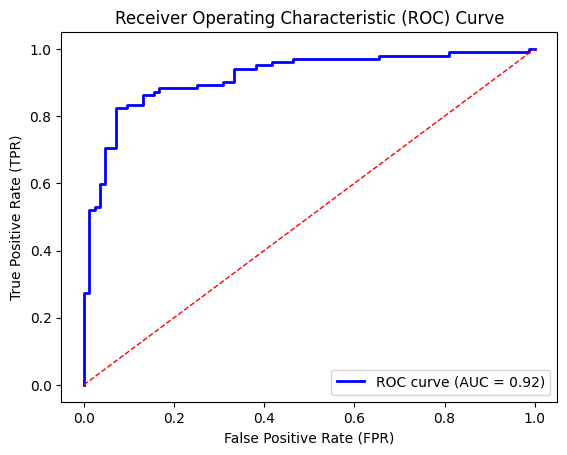

In [275]:
accuracy, precision, tpr, fpr, f1_score = calculate_metrics(cm)
print(f'accuracy: {accuracy}, precision: {precision}, tpr: {tpr}, fpr: {fpr}, f1_score: {f1_score}')

y_probs = best_RFC_grid.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
roc_auc = metrics.roc_auc_score(y_test, y_probs)

plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


We got really good result so we will say that its the best Random Forest classifier

In [276]:
best_Random_Forest = best_RFC_grid

# XGBoost

Now we will try now algorithem which we didn't cover in the class. We expline the idea of him in the report.

In [277]:
X_train, X_test, y_train, y_test = train_test_split(training_df, y, test_size=0.25, random_state=42) 
clf_xg = XGBClassifier(booster='gbtree', learning_rate=0.1, max_depth=7,
                        reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
                        tree_method='exact')
clf_xg.fit(X_train, y_train)
y_pred = clf_xg.predict(X_test)
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)))
print(metrics.classification_report(y_test,y_pred))

    0   1
0  72  12
1  13  89
              precision    recall  f1-score   support

           0       0.85      0.86      0.85        84
           1       0.88      0.87      0.88       102

    accuracy                           0.87       186
   macro avg       0.86      0.86      0.86       186
weighted avg       0.87      0.87      0.87       186



We saw already good results so we will aplly a Random search to find the best parameters for this classifier.

In [278]:
X_train, X_test, y_train, y_test = train_test_split(training_df, y, test_size=0.25, random_state=42)
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7],
                'min_child_weight': [1, 3, 5],
                'gamma': [0, 0.1, 0.2],
                'reg_alpha' : [0.1, 0.01, 0.001],
                'reg_lambda' : [0.1, 0.01, 0.001],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]}

XGboost_classfier = XGBClassifier(random_state = 42, tree_method='exact')
XGC = RandomizedSearchCV(XGboost_classfier, param_distributions = param_grid
                         , n_iter = 50, cv = 5, scoring='accuracy')

XGC.fit(X_train, y_train)
best_XGC = XGC.best_estimator_
y_pred = best_XGC.predict(X_test)
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)))
print(metrics.classification_report(y_test,y_pred))


    0   1
0  68  16
1  17  85
              precision    recall  f1-score   support

           0       0.80      0.81      0.80        84
           1       0.84      0.83      0.84       102

    accuracy                           0.82       186
   macro avg       0.82      0.82      0.82       186
weighted avg       0.82      0.82      0.82       186



We saw even better result, but we want more so we will aplly bayesian optimization algorithm.

In [279]:
X_train, X_test, y_train, y_test = train_test_split(training_df, y, test_size=0.25, random_state=42)

space = {
    "colsample_bytree": hp.uniform('colsample_bytree', 0.7, 1.0),
    "gamma": hp.uniform('gamma', 0, 0.5),
    "learning_rate": hp.uniform('learning_rate', 0.003, 0.3),
    "max_depth": hp.randint('max_depth', 2, 7),
    "n_estimators": hp.randint('n_estimators', 50, 250),
    "subsample": hp.uniform('subsample', 0.6, 1.0),
    'min_child_weight': hp.uniform('min_child_weight', 1, 6),
    'reg_alpha': hp.uniform('reg_alpha', 0.003, 0.303),
    'reg_lambda': hp.uniform('reg_lambda', 0.003, 0.303),
    'random_state' : 42,
}
def objective(params):
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    return -accuracy  # Minimize the negative accuracy

algo = tpe.suggest
trials = Trials()
best = fmin(objective, space, algo=algo, trials=trials, max_evals=500)

best_params = space_eval(space, best)
best_XGBC = XGBClassifier(**best_params)
best_XGBC.fit(X_train, y_train)
y_pred_test = best_XGBC.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_pred_test)
cm = metrics.confusion_matrix(y_test, y_pred_test)
print("Best Hyperparameters:", best_params)
print("Test Accuracy:", test_accuracy)


100%|██████████| 500/500 [01:16<00:00,  6.54trial/s, best loss: -0.8924731182795699]
Best Hyperparameters: {'colsample_bytree': 0.8918349309495831, 'gamma': 0.19212601186865605, 'learning_rate': 0.018937580566195628, 'max_depth': 5, 'min_child_weight': 3.038534846280233, 'n_estimators': 139, 'random_state': 42, 'reg_alpha': 0.14035923610227302, 'reg_lambda': 0.19140632842757213, 'subsample': 0.9850014595157727}
Test Accuracy: 0.8924731182795699


Seeing that its the best model so far and it has high accuracy we want to see all of its parameters, especially precision.

accuracy: 0.8924731182795699, precision: 0.8809523809523809, tpr: 0.8809523809523809, fpr: 0.09803921568627451, f1_score: 0.8809523809523809


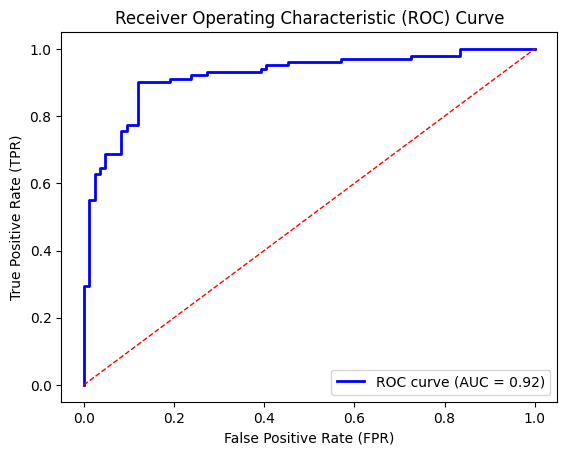

In [280]:
accuracy, precision, tpr, fpr, f1_score = calculate_metrics(cm)
print(f'accuracy: {accuracy}, precision: {precision}, tpr: {tpr}, fpr: {fpr}, f1_score: {f1_score}')

y_probs = best_XGBC.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
roc_auc = metrics.roc_auc_score(y_test, y_probs)

plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

We want to try fit him on balanced data and predict the output on inbalaced data 

In [281]:
X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(training_df_init, y_init, test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(training_df, y, test_size=0.25, random_state=42)
best_XGBC.fit(X_train, y_train)
y_pred_test = best_XGBC.predict(X_test_init)
test_accuracy = metrics.accuracy_score(y_test_init, y_pred_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8982035928143712


We saw that we got a really good model, so we will stop here

In [282]:
best_XGboost = best_XGBC

# K-Nearest Neighbours

We will try using KNN algorithem with changing the distance metrics and the number of neighbours.

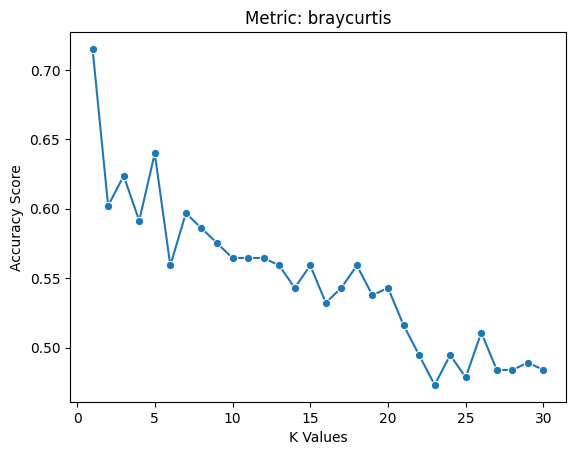

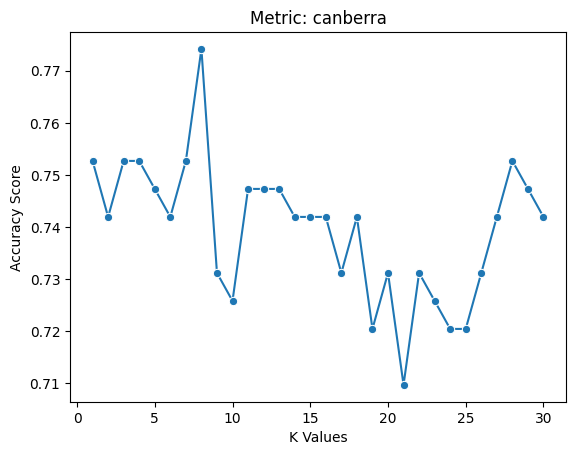

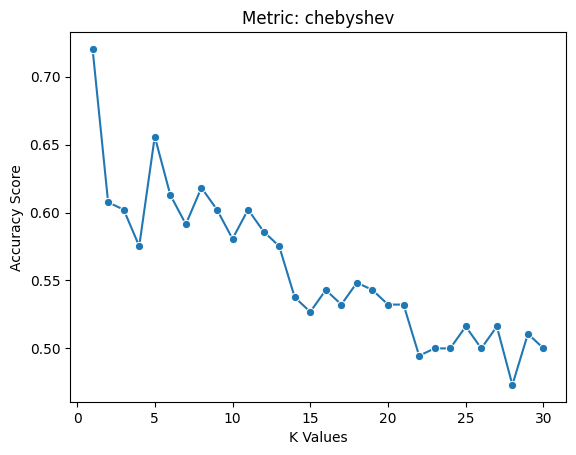

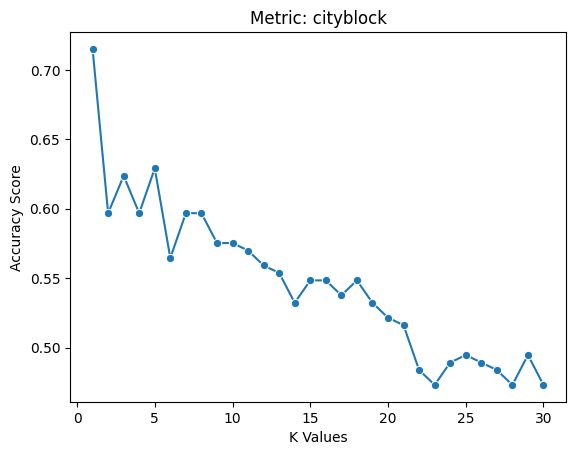

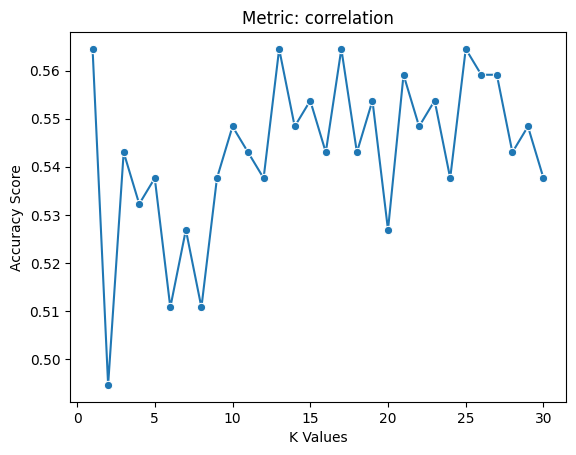

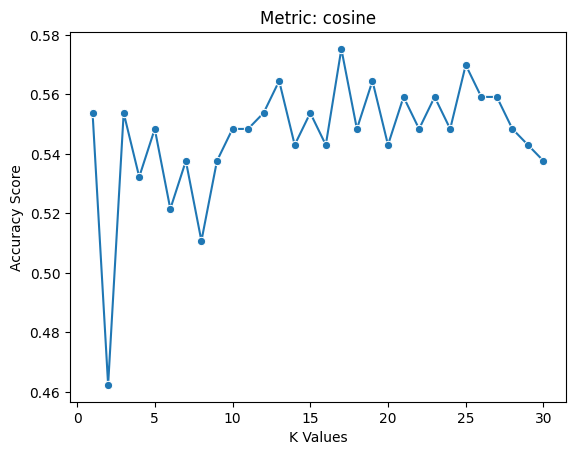

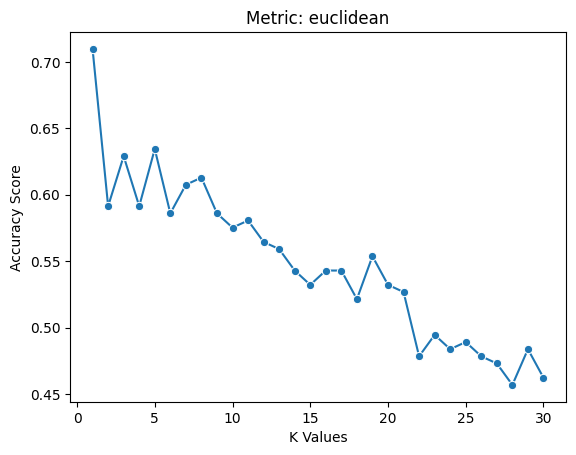

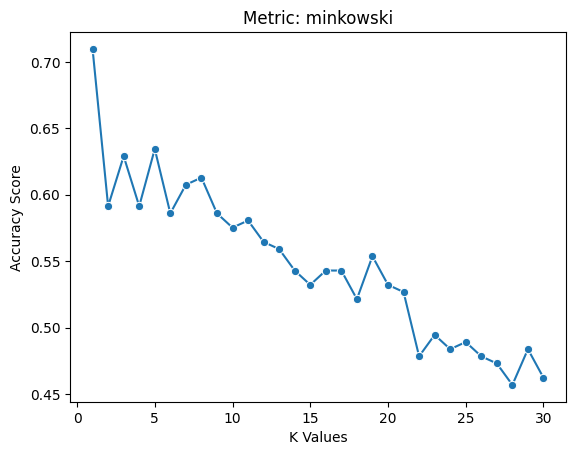

In [283]:
X_train, X_test, y_train, y_test = train_test_split(training_df, y, test_size=0.25)

scores = {}

_metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
             'cosine', 'euclidean','minkowski']

for metric in _metrics:
    scores[metric] = []
    for k in range(1, 31):
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        scores[metric].append(metrics.accuracy_score(y_test, y_pred))

for metric in _metrics:
    sns.lineplot(x=range(1,31), y=scores[metric], marker='o')
    plt.xlabel("K Values")
    plt.ylabel("Accuracy Score")
    plt.title(f'Metric: {metric}')
    plt.show()

We want to find if changing leaf_size will lead to better results w.r.t k

In [284]:
max_score = 0
best_model = None

for k in range(1, 51):
    for leaf_size in range(20, 101):
        knn = KNeighborsClassifier(n_neighbors=k, leaf_size=leaf_size, weights='distance', p=1)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        if metrics.accuracy_score(y_test, y_pred) > max_score:
            max_score = metrics.accuracy_score(y_test, y_pred)
            best_model = knn

print(f'Accuracy: {max_score}')
print(best_model.get_params)

Accuracy: 0.7150537634408602
<bound method BaseEstimator.get_params of KNeighborsClassifier(leaf_size=20, n_neighbors=1, p=1, weights='distance')>


This is the best model we got of K-Nearest Neighbors and therefore we will save it

In [285]:
best_knn = best_model

# Logisic Regression

We will try to test the LogisticRegression classifier with no hyperparameters

In [286]:
logreg = LogisticRegression(random_state = 42, max_iter = 5000)
scores = cross_val_score(logreg, training_df, y, cv=5, scoring='accuracy')

print("Accuracy scores:", scores)
mean_accuracy = scores.mean()
print("Mean accuracy:", mean_accuracy)

Accuracy scores: [0.70469799 0.67114094 0.70469799 0.69798658 0.75      ]
Mean accuracy: 0.7057046979865771


Now, we will try to use the bayesian optimization algorithms to find the best hyperparameters the this model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(training_df, y, test_size=0.25, random_state=42)

space = {
    "C": hp.uniform('C', 0.01, 100),
    "penalty": hp.choice('penalty', ['l2', None]),
    "solver": hp.choice('solver', ['lbfgs', 'sag', 'saga']),
    "max_iter": hp.randint('max_iter', 100, 10000),
    "fit_intercept": hp.choice('fit_intercept', [True, False]),
    "class_weight": 'balanced',
    'multi_class': hp.choice('multi_class', ['ovr', 'multinomial']),
    'tol': hp.uniform('tol', 1e-5, 1e-3),
    'random_state' : 42
}



def objective(params):
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    return -accuracy

algo = tpe.suggest
trials = Trials()
best = fmin(objective, space, algo=algo, trials=trials, max_evals=500)

best_params = space_eval(space, best)
best_LR = LogisticRegression(**best_params)
best_LR.fit(X_train, y_train)
y_pred_test = best_LR.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_pred_test)
print("Best Hyperparameters:", best_params)
print("Test Accuracy:", test_accuracy)

In [288]:
print("Best Hyperparameters:", best_params)
print("Test Accuracy:", test_accuracy)

Best Hyperparameters: {'C': 36.018657737548594, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 6343, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0003026023087189903}
Test Accuracy: 0.7849462365591398


We saw improvmet of 8 precent, which is really high. We will save this model as the best one from the Logistic Regression classifiers 

In [289]:
best_Logisic_Regression = best_LR

# Prediction of the test

Selecting the best model has the best_XGbooster has it gave us the best results in accuracy and precision

In [290]:
model = best_XGboost

Predicting the test dataset and saving him in csv file

In [294]:
target = pd.DataFrame(model.predict(test_df))
target.to_csv("Target.csv", index=False)